In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import levene
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind, mannwhitneyu
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df_2023= pd.read_csv('data/2023/외래관광객조사_2023_전처리3(세분화).csv')
df_2024= pd.read_csv('data/2024/외래관광객조사_2024_전처리3(세분화).csv')

In [3]:
# 2024년 컬럼명 통일
df_2024.rename(columns={
    '총액1인TOT_개별국제교통비제외2': '총액1인TOT항공제외2'
}, inplace=True)

In [4]:
print('총액1인TOT_개별국제교통비제외2' in df_2024.columns)

False


In [5]:
print('총액1인TOT항공제외2' in df_2024.columns)

True


In [6]:
print(df_2024.columns.tolist())

['D_NAT', 'M일HAP', 'Q7A', 'Q7a_dk', 'Q7a2', 'Q7a3', 'Q7a4', 'Q7a5', 'Q7a6', 'Q7a7', 'Q7a8', 'D_GUB', 'D_MOK', '총액1인TOT항공제외2', 'Q8a03', 'Q8a12', 'Q8_1a1', 'Q8_1a2', 'Q8_1a3', 'D_AGE', '동행자_단순', '동행자_세분화', '국가명', '연령대_단순', '연령대_세분화', '웰니스참여', '웰니스만족', 'log_총액', 'year']


In [7]:
# 23, 24년도 데이터 병합
df_all = pd.concat([df_2023, df_2024], ignore_index=True)

In [8]:
# 병합된 데이터 확인
print(df_all.shape)
print(df_all['year'].value_counts())  # 연도별 분포 확인

(17123, 29)
year
2024    8769
2023    8354
Name: count, dtype: int64


### 연령대별 사용 총액 분석

In [9]:
df_all['연령대_단순'].value_counts()

연령대_단순
30~50대    9596
20대       6117
60대 이상     974
10대        436
Name: count, dtype: int64

In [10]:
# 연령대별 평균 총액
avg_total_by_age = df_all.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().round(1).sort_index()
print(avg_total_by_age)

연령대_단순
10대       1160.0
20대       1268.6
30~50대    1445.3
60대 이상    1252.9
Name: 총액1인TOT항공제외2, dtype: float64


- 30~50대가 총액1인소비가 가장 큰 그룹으로 나타남
- 30~50대 > 20대 > 60대 이상 > 10대 순으로 연령대별 평균 소비 총액을 확인할 수 있음 

In [11]:
df_all['연령대_세분화'].value_counts()

연령대_세분화
20대       6117
30대       4189
50대       2776
40대       2631
60대 이상     974
10대        436
Name: count, dtype: int64

In [12]:
# 연령대별 평균 총액
avg_total_by_age = df_all.groupby('연령대_세분화')['총액1인TOT항공제외2'].mean().round(1).sort_index()
print(avg_total_by_age)

연령대_세분화
10대       1160.0
20대       1268.6
30대       1465.3
40대       1476.9
50대       1385.0
60대 이상    1252.9
Name: 총액1인TOT항공제외2, dtype: float64


In [13]:
print(df_all['총액1인TOT항공제외2'].describe())

count    17123.000000
mean      1363.952237
std       1272.311095
min        139.800000
25%        665.133847
50%        987.620000
75%       1561.700000
max       9549.510000
Name: 총액1인TOT항공제외2, dtype: float64


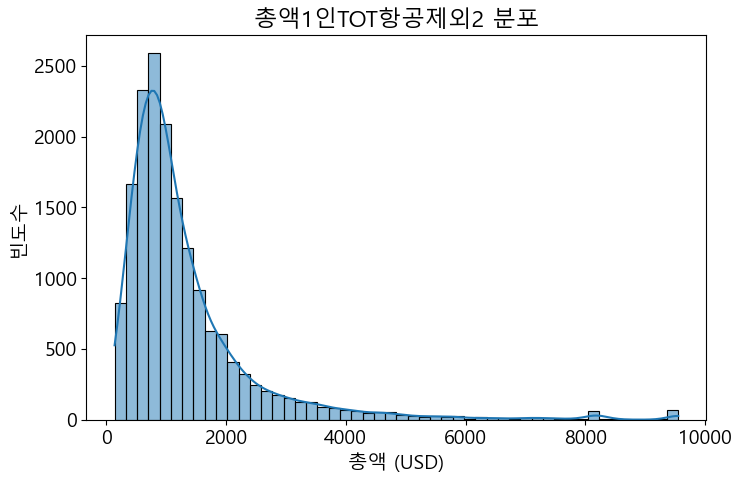

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(df_all['총액1인TOT항공제외2'], bins=50, kde=True)
plt.title("총액1인TOT항공제외2 분포")
plt.xlabel("총액 (USD)")
plt.ylabel("빈도수")
plt.show()

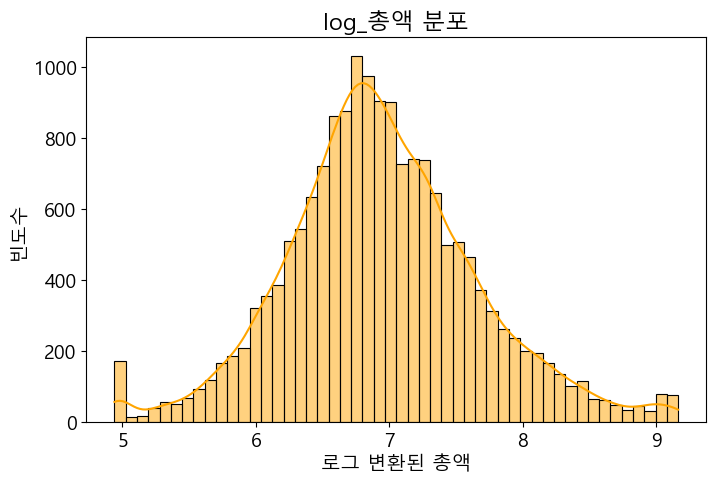

In [15]:
plt.figure(figsize=(8, 5))
sns.histplot(df_all['log_총액'], bins=50, kde=True, color='orange')
plt.title("log_총액 분포")
plt.xlabel("로그 변환된 총액")
plt.ylabel("빈도수")
plt.show()

In [16]:
# 연령대별 평균 log_총액 구하기
avg_log_by_age = df_all.groupby('연령대_단순')['log_총액'].mean().round(3)
print(avg_log_by_age)

연령대_단순
10대       6.798
20대       6.870
30~50대    7.003
60대 이상    6.829
Name: log_총액, dtype: float64


In [17]:
df_all['예상_총액'] = np.exp(df_all['log_총액']) - 1

In [18]:
avg_total_by_age = df_all.groupby('연령대_단순')['예상_총액'].mean().round(1)
print(avg_total_by_age)

연령대_단순
10대       1159.0
20대       1267.6
30~50대    1444.3
60대 이상    1251.9
Name: 예상_총액, dtype: float64


### 연령대별 자녀 동반 여부에 따른 소비 총액 차이

#### 연령대_단순 기준 
- 10대, 20대, 30~50대, 60대 이상

In [19]:
# 동행자_세분화 컬럼 중에서 '자녀'와 함께온 관광객은 자녀O, 아닌 그룹은 자녀X 그룹으로 나눔
df_all['자녀동반'] = df_all['동행자_세분화'].apply(lambda x: '자녀O' if x == '자녀' else '자녀X')

In [20]:
df_all['연령대_단순'].value_counts()

연령대_단순
30~50대    9596
20대       6117
60대 이상     974
10대        436
Name: count, dtype: int64

In [21]:
df_all.query("자녀동반 == '자녀O'").groupby('연령대_단순').size()

연령대_단순
10대         1
20대        15
30~50대    698
60대 이상    114
dtype: int64

In [22]:
print(df_all['자녀동반'].unique())

['자녀X' '자녀O']


In [23]:
# 10대 제외 필터링
df_filtered = df_all[df_all['연령대_단순'] != '10대']

In [24]:
# 연령대별 × 자녀 동반 여부별 평균 소비액 확인
## 예상 총액 기준으로 평균 비교
pivot = df_filtered.pivot_table(
    index='연령대_단순',
    columns='자녀동반',
    values='예상_총액',
    aggfunc='mean'
).round(1)

print(pivot)

자녀동반       자녀O     자녀X
연령대_단순                
20대     1360.4  1267.4
30~50대  1298.2  1455.7
60대 이상  1172.4  1262.5


In [25]:
# 자녀 동반 비율
# 전체 인원 수
total = df_filtered.groupby('연령대_단순').size()

# 자녀동반 인원 수
with_child = df_filtered[df_filtered['자녀동반'] == '자녀O'].groupby('연령대_단순').size()

# 비율 계산
pivot['자녀동반비율'] = (with_child / total * 100).round(1).astype(str) + '%'

print(with_child)
pivot['자녀동반비율']

연령대_단순
20대        15
30~50대    698
60대 이상    114
dtype: int64


연령대_단순
20대        0.2%
30~50대     7.3%
60대 이상    11.7%
Name: 자녀동반비율, dtype: object

| 연령대     | 자녀O 평균 소비액 | 자녀X 평균 소비액 | 차이 (자녀X - 자녀O)            |
| ------- | ---------- | ---------- | ------------------------- |
| 20대     | \$1,360.4  | \$1,267.4  | **-93.0** (자녀 동반 시 소비 ↑)  |
| 30\~50대 | \$1,298.2  | \$1,455.7  | **+157.5** (자녀 동반 시 소비 ↓) |
| 60대 이상  | \$1,172.4  | \$1,262.5  | **+90.1** (자녀 동반 시 소비 ↓)  |


- 20대만 자녀 동반 시 소비가 증가 (다만, 표본수가 다른 그룹보다 적기에 신뢰도 낮음)
- 30~50대는 자녀 동반 시 평균 소비 감소 (30~50대 전체 표본수에 비해 자녀와 함계한 30~50대의 표본차가 큼)
- 자녀 미동반 시 평균 소비가 약 $157 더 높음
- 자녀 동반 시 비용 부담을 줄이거나, 여행 스타일 자체가 달라질 가능성 존재
- 체험 위주 -> 실내/단기 체류
- 60대도 비슷한 경향
- 자녀 미동반 시 소비가 더 높음
- 다만 전반적으로 평균 소비 자체가 낮음 (60대 특징)

- 30~50대: 자녀 없이 여행하는 중장년층이 가장 높은 소비력 보유층으로 타겟팅 가치 큼
- 60대 이상: 자녀와 함께 여행하더라도 소비는 제한적 → 저가형, 휴식형 콘텐츠 전략 적합

#### 연령대_세분화 기준

In [26]:
df_all.query("자녀동반 == '자녀O'").groupby('연령대_세분화').size()

연령대_세분화
10대         1
20대        15
30대       113
40대       206
50대       379
60대 이상    114
dtype: int64

In [27]:
# 10대 제외 필터링
df_filtered = df_all[df_all['연령대_세분화'] != '10대']

In [28]:
# 연령대별 × 자녀 동반 여부별 평균 소비액 확인
## 예상 총액 기준으로 평균 비교
pivot = df_filtered.pivot_table(
    index='연령대_세분화',
    columns='자녀동반',
    values='예상_총액',
    aggfunc='mean'
).round(1)

print(pivot)

자녀동반        자녀O     자녀X
연령대_세분화                
20대      1360.4  1267.4
30대      1329.7  1468.1
40대      1424.3  1480.2
50대      1220.3  1409.9
60대 이상   1172.4  1262.5


### 왜 자녀를 동반하면 소비가 줄어들까?

1. 1인당 지출이 분산됨
- 숙소·음식·이동 등에서 전체 비용은 증가하나, 개별 체험/사치 지출은 감소

2. 자녀 중심 일정으로 전환됨
- 웰니스 콘텐츠(명상, 뷰티, 스파 등)는 어른 중심 활동
- 자녀가 있으면 소극적 선택, 체험 종류 제한됨

3. 예산 조정 심리
- 가족 단위 여행은 전체 예산이 커지므로, 개별 항목에서 지출 절제

4. 왜 30~50대 자녀 미동반자는 핵심 소비자인가?
- 경제활동 주력층 + 체력과 여가 모두 확보된 세대
- 자녀 없이 여행할 경우: 자기만족 중심 소비 가능
- 웰니스 콘텐츠(명상, 스파, 치유 등)에 높은 관심과 지출 여력

5. 결론
- 웰니스 관광의 핵심 소비자는 ‘자녀 없이 여행하는 30~50대’다.

- 관광객 / 웰니스 관광객 구분해서 더 분석해보기

## 웰니스 관광객 사용 총액 분석

In [51]:
# 웰니스 관광객만 필터링
wellness_df = df_all[df_all['웰니스참여'] == 1]

In [53]:
wellness_df

,D_NAT,M일HAP,Q7A,Q7a_dk,Q7a2,Q7a3,Q7a4,Q7a5,Q7a6,Q7a7,...,동행자_세분화,국가명,연령대_단순,연령대_세분화,웰니스참여,웰니스만족,log_총액,year,예상_총액,자녀동반
1,1,7,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,혼자,중국,30~50대,30대,1,1,7.390971,2023,1620.280000,자녀X
4,3,8,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,대만,20대,20대,1,1,7.197884,2023,1335.600000,자녀X
7,5,6,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,홍콩,30~50대,30대,1,1,7.490440,2023,1789.840000,자녀X
8,3,6,2,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,배우자/파트너,대만,20대,20대,1,1,6.691116,2023,804.220000,자녀X
9,3,5,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,대만,30~50대,30대,1,1,7.210006,2023,1351.900000,자녀X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17117,1,5,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,중국,20대,20대,1,1,6.204900,2024,494.169633,자녀X
17118,1,5,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,중국,30~50대,40대,1,1,6.053570,2024,424.630000,자녀X
17120,1,5,2,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,자녀,중국,30~50대,50대,1,1,7.845392,2024,2552.938220,자녀O
17121,1,5,2,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,배우자/파트너,중국,30~50대,50대,1,1,6.426246,2024,616.850000,자녀X


In [54]:
# 웰니스 관광객 연령대 분포
wellness_df['연령대_단순'].value_counts()

연령대_단순
30~50대    6243
20대       3693
60대 이상     643
10대        247
Name: count, dtype: int64

In [48]:
# 전체 연령대 분포
df_all['연령대_단순'].value_counts()

연령대_단순
30~50대    9596
20대       6117
60대 이상     974
10대        436
Name: count, dtype: int64

In [81]:
# 연령대별 비율 
ratio_by_age = (wellness_df['연령대_단순']
                .value_counts(normalize=True)
                .sort_index() * 100).round(1)

print(ratio_by_age)

연령대_단순
20대       34.9
30~50대    59.0
60대 이상     6.1
Name: proportion, dtype: float64


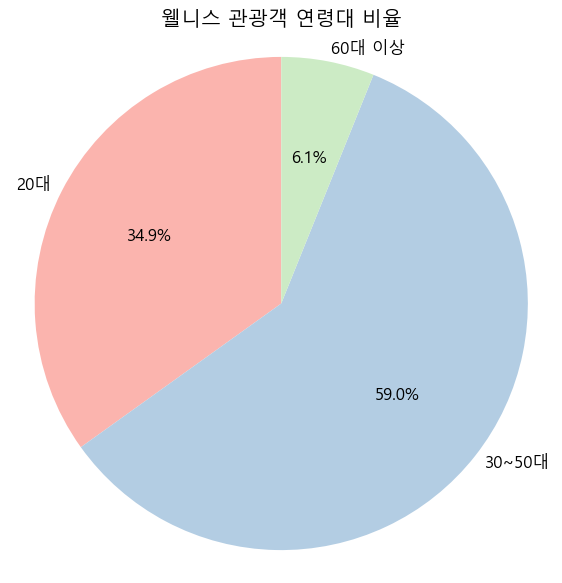

In [89]:
# 연령대 비율 시각화
labels = ratio_by_age.index.tolist()
sizes = ratio_by_age.values.tolist()

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Pastel1.colors,
    labeldistance=1.05  # ← 조각과 라벨의 거리 조절 (기본값은 1.1)
)
plt.title('웰니스 관광객 연령대 비율')
plt.axis('equal')
plt.show()

In [55]:
# 10대 제외
wellness_df = wellness_df[wellness_df['연령대_단순'] != '10대']

In [32]:
# 연령대별 평균 예상 총액
avg_total = wellness_df.groupby('연령대_단순')['예상_총액'].mean().round(1)
print(avg_total)

연령대_단순
20대       1279.4
30~50대    1429.0
60대 이상    1301.1
Name: 예상_총액, dtype: float64


In [66]:
avg_total = wellness_df.groupby('연령대_세분화')['예상_총액'].mean().round(1)
print(avg_total)

연령대_세분화
20대       1279.4
30대       1449.5
40대       1434.6
50대       1395.9
60대 이상    1301.1
Name: 예상_총액, dtype: float64


C:\Users\82106\AppData\Local\Temp\ipykernel_26476\618232424.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='연령대_단순', y='예상_총액', data=avg_total_df, palette='Blues_d')


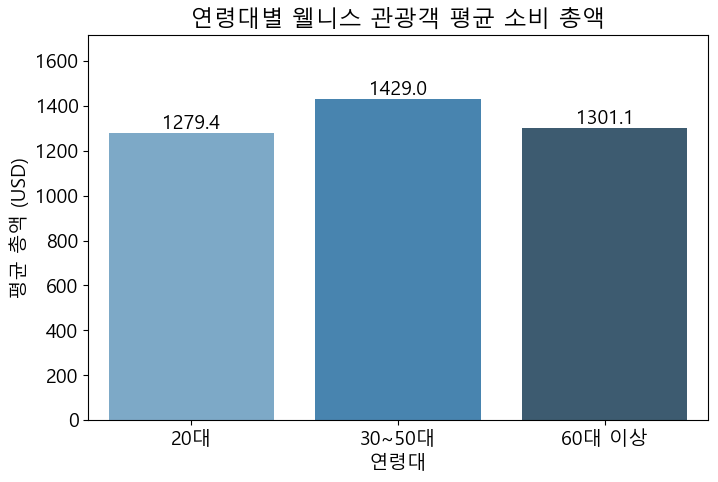

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화용 DataFrame으로 변환
avg_total_df = wellness_df.groupby('연령대_단순')['예상_총액'].mean().round(1).reset_index()

# 그래프 그리기
plt.figure(figsize=(8, 5))
sns.barplot(x='연령대_단순', y='예상_총액', data=avg_total_df, palette='Blues_d')
plt.title('연령대별 웰니스 관광객 평균 소비 총액')
plt.xlabel('연령대')
plt.ylabel('평균 총액 (USD)')
plt.ylim(0, avg_total_df['예상_총액'].max() * 1.2)  # y축 여유롭게

# 막대 위에 값 표시
for i, row in avg_total_df.iterrows():
    plt.text(i, row['예상_총액'] + 20, f"{row['예상_총액']}", ha='center')

plt.show()

- 30~50대: 전체 참여자의 59% 차지 + 평균 소비 최고 -> 웰니스 시장의 압도적 핵심 타겟
- 20대: 약 35%의 비율로 비교적 많이 참여 -> 참여율은 높지만 소비는 가장 낮음 -> 저가 체험형 콘텐츠 (가성비)
- 60대 이상: 소수지만 탄탄한 수요층 -> 참여자는 6.1%로 적지만 평균 소비는 1,300달러 수준 -> 건강 치유형 콘텐츠 타겟, 소규모 집중 마케팅
- 웰니스 관광은 30~50대가 양적·질적으로 모두 핵심이며, 20대는 참여 유도층, 60대는 치유형 니치 마켓으로 활용 가능하다.

C:\Users\82106\AppData\Local\Temp\ipykernel_26476\1022846865.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='연령대_세분화', y='예상_총액', data=avg_total_df, palette='Blues_d')


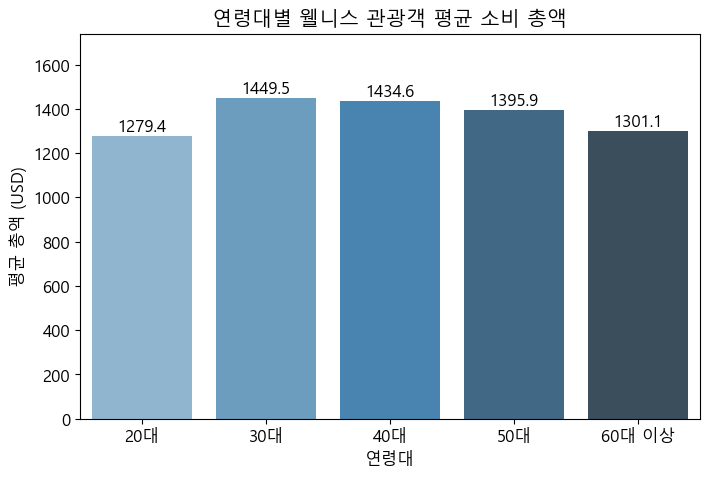

In [67]:
# 시각화용 DataFrame으로 변환
avg_total_df = wellness_df.groupby('연령대_세분화')['예상_총액'].mean().round(1).reset_index()

# 그래프 그리기
plt.figure(figsize=(8, 5))
sns.barplot(x='연령대_세분화', y='예상_총액', data=avg_total_df, palette='Blues_d')
plt.title('연령대별 웰니스 관광객 평균 소비 총액')
plt.xlabel('연령대')
plt.ylabel('평균 총액 (USD)')
plt.ylim(0, avg_total_df['예상_총액'].max() * 1.2)  # y축 여유롭게

# 막대 위에 값 표시
for i, row in avg_total_df.iterrows():
    plt.text(i, row['예상_총액'] + 20, f"{row['예상_총액']}", ha='center')

plt.show()

- 30, 40대가 가장 큰 웰니스 관광 소비층 
- 30~50대 전체를 핵심 소비군으로 묶는 전략 가능

###  웰니스 관광객 × 자녀 동반 여부에 따른 소비 총액 분석

In [60]:
# 웰니스 참여자 중 자녀 동반자 연령대 
wellness_with_child = df_all[(df_all['웰니스참여'] == 1) & (df_all['자녀동반'] == '자녀O')]

In [64]:
wellness_with_child['연령대_단순'].value_counts()

연령대_단순
30~50대    436
60대 이상     71
20대        11
10대         1
Name: count, dtype: int64

In [65]:
wellness_with_child['연령대_세분화'].value_counts()

연령대_세분화
50대       248
40대       118
60대 이상     71
30대        70
20대        11
10대         1
Name: count, dtype: int64

In [90]:
# 10대 제외
wellness_with_child = wellness_with_child[wellness_with_child['연령대_단순'] != '10대']

In [91]:
# 연령대별 비율 (%) 계산
child_ratio = (wellness_with_child['연령대_단순']
               .value_counts(normalize=True)
               .sort_index() * 100).round(1)

print(child_ratio)

연령대_단순
20대        2.1
30~50대    84.2
60대 이상    13.7
Name: proportion, dtype: float64


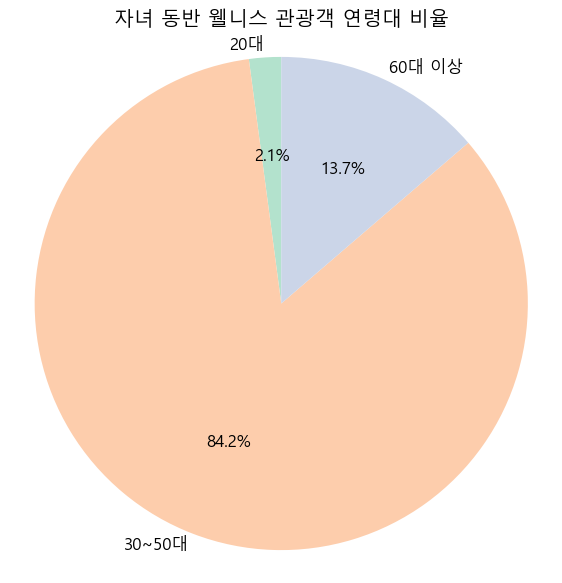

In [92]:
import matplotlib.pyplot as plt

labels = child_ratio.index.tolist()
sizes = child_ratio.values.tolist()

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Pastel2.colors, 
    labeldistance=1.05  # 라벨과 그래프 조각 간 거리 좁힘
)
plt.title('자녀 동반 웰니스 관광객 연령대 비율')
plt.axis('equal')  # 원형 유지
plt.show()

In [33]:
# 자녀 동반 여부별 평균 총액
pivot_wellness = wellness_df.pivot_table(
    index='연령대_단순',
    columns='자녀동반',
    values='예상_총액',
    aggfunc='mean'
).round(1)

print(pivot_wellness)

자녀동반       자녀O     자녀X
연령대_단순                
20대     1634.3  1278.3
30~50대  1344.6  1435.3
60대 이상  1152.7  1319.5


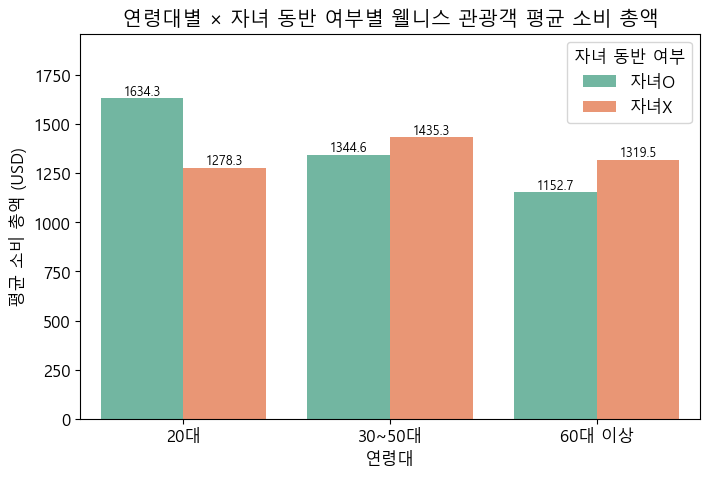

In [56]:
# 시각화
# 1. Pivot → Long Format 변환
pivot_wellness_reset = pivot_wellness.reset_index()

pivot_melted = pivot_wellness_reset.melt(
    id_vars='연령대_단순', 
    value_vars=['자녀O', '자녀X'],
    var_name='자녀동반', 
    value_name='예상_총액'
)

# 2. Grouped Barplot 그리기
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='연령대_단순', 
    y='예상_총액', 
    hue='자녀동반', 
    data=pivot_melted, 
    palette='Set2'
)
plt.title('연령대별 × 자녀 동반 여부별 웰니스 관광객 평균 소비 총액')
plt.xlabel('연령대')
plt.ylabel('평균 소비 총액 (USD)')
plt.legend(title='자녀 동반 여부')
plt.ylim(0, pivot_melted['예상_총액'].max() * 1.2)

# 3. 막대 위 숫자 표시
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height != 0.0:  # NaN 및 0.0 모두 방지
        ax.annotate(f'{height:.1f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=9)
plt.show()


- 30~50대가 자녀 동반 웰니스의 실질 타겟 (10명 중 8명 이상이 이 연령대)
- 가족 중심 콘텐츠, 프리미엄 숙소/리조트, 쇼핑 연계형 웰니스 전략 적합
- 60대 이상은 자녀와 동반 여행할 가능성 존재 (전체의 13.7% 차지 → 니치 타겟 가능)
- 건강/치유형 콘텐츠 + 효도형 여행 마케팅 전략 활용 가능
- 20대는 분석상 제외 가능 -> 자녀 동반은 의미 없는 수준 (2.1%)
- 개별 소비자 중심 마케팅이 적절 (가성비 중심)

- 30~50대: 자녀 없이 여행할 때 소비 높음 -> 자녀를 동반하지 않았을 때 소비가 약 91달러 더 높음
- 이 연령대는 자녀 없이 여유롭게 고가 소비하는 특성이 뚜렷 → 웰니스 프리미엄 콘텐츠 타겟 확정
- 60대 이상도 자녀 미동반이 더 많이 씀 -> 자녀를 동반하지 않은 경우 약 167달러 더 소비
- 단독/부부 여행자 중심 소비 성향 → 건강/치유 콘텐츠 중심, 가격 민감층 고려

1. 자녀 동반 시 소비 감소 경향
- 30~50대, 60대 이상 공통
- 자녀 동반 여행은 소비 분산 및 절제 경향
- 개별 또는 부부 여행자 중심 마케팅이 효과적

2. 웰니스 핵심 소비자 = 자녀 없이 여행하는 중장년층
- 타겟: 30~50대 자녀 미동반층
- 전략: 프리미엄 스파/명상/힐링 콘텐츠, 고급 숙소 연계

In [70]:
# 자녀 동반 여부별 평균 총액 (연령대 세분화)
pivot_wellness2 = wellness_df.pivot_table(
    index='연령대_세분화',
    columns='자녀동반',
    values='예상_총액',
    aggfunc='mean'
).round(1)

print(pivot_wellness2)

자녀동반        자녀O     자녀X
연령대_세분화                
20대      1634.3  1278.3
30대      1159.8  1457.5
40대      1572.8  1424.5
50대      1288.3  1412.0
60대 이상   1152.7  1319.5


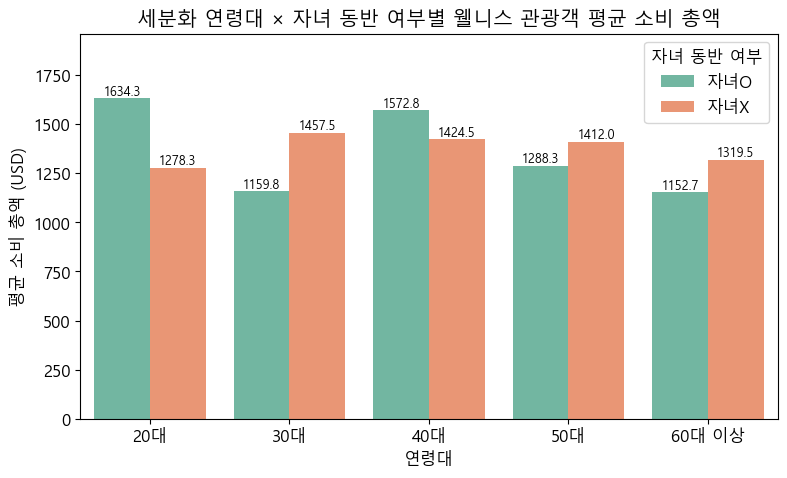

In [95]:
# 시각화 
pivot_reset = pivot_wellness2.reset_index()

pivot_melted = pivot_reset.melt(
    id_vars='연령대_세분화', 
    value_vars=['자녀O', '자녀X'],
    var_name='자녀동반', 
    value_name='예상_총액'
)

plt.figure(figsize=(9, 5))
ax = sns.barplot(
    x='연령대_세분화', 
    y='예상_총액', 
    hue='자녀동반', 
    data=pivot_melted, 
    palette='Set2'
)
plt.title('세분화 연령대 × 자녀 동반 여부별 웰니스 관광객 평균 소비 총액')
plt.xlabel('연령대')
plt.ylabel('평균 소비 총액 (USD)')
plt.legend(title='자녀 동반 여부')
plt.ylim(0, pivot_melted['예상_총액'].max() * 1.2)

# 막대 위 숫자 표시 (소수점 1자리)
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height != 0.0:
        ax.annotate(f'{height:.1f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=9)

plt.show()


In [96]:
# 자녀 동반 웰니스 관광객만 필터링
wellness_with_child = df_all[(df_all['웰니스참여'] == 1) & (df_all['자녀동반'] == '자녀O')]

# 연령대별 평균 소비 총액 계산
mean_by_age = wellness_with_child.groupby('연령대_단순')['예상_총액'].mean().round(1)

print(mean_by_age)

연령대_단순
10대       1705.3
20대       1634.3
30~50대    1344.6
60대 이상    1152.7
Name: 예상_총액, dtype: float64


In [93]:
# 자녀 동반 웰니스 관광객만 필터링 (20대 포함 전체 대상)
wellness_with_child = df_all[(df_all['웰니스참여'] == 1) & (df_all['자녀동반'] == '자녀O')]

# 연령대별 중앙값 계산
median_by_age = wellness_with_child.groupby('연령대_단순')['예상_총액'].median().round(1)
print(median_by_age)

연령대_단순
10대       1705.3
20대       1293.6
30~50대     966.7
60대 이상     877.5
Name: 예상_총액, dtype: float64


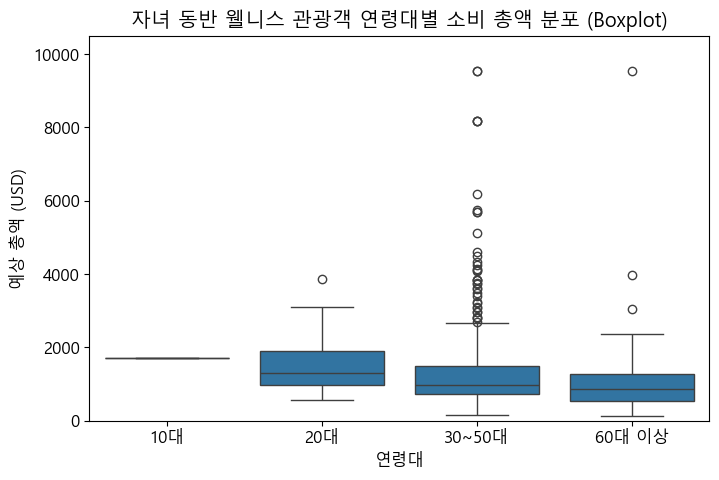

In [94]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='연령대_단순', y='예상_총액', data=wellness_with_child, order=sorted(wellness_with_child['연령대_단순'].unique()))
plt.title('자녀 동반 웰니스 관광객 연령대별 소비 총액 분포 (Boxplot)')
plt.xlabel('연령대')
plt.ylabel('예상 총액 (USD)')
plt.ylim(0, wellness_with_child['예상_총액'].max() * 1.1)
plt.show()


| 연령대     | 평균 소비 (USD) | 중앙값 (USD)   | 차이 (평균 - 중앙값) | 해석                 |
| ------- | ----------- | ----------- | ------------- | ------------------ |
| 10대     | 1,705.3     | 1,705.3     | 0.0           | 샘플 수 **1명**, 무의미   |
| 20대     | **1,634.3** | **1,293.6** | **+340.7**    | 평균 **왜곡 심각**       |
| 30\~50대 | 1,344.6     | 966.7       | +377.9        | 왜곡 있지만 **샘플 수 충분** |
| 60대 이상  | 1,152.7     | 877.5       | +275.2        | 왜곡 있으나 **타겟 가능**   |


| 연령대     | 평균 신뢰도    | 해석                       |
| ------- | --------- | ------------------------ |
| 10대     | 샘플 1명 | 분석 제외                    |
| 20대     | 평균 과대   | 실제 소비는 낮음 → **고액 소비 착시** |
| 30\~50대 | 샘플 충분 | 평균과 중앙값 모두 참고 → 핵심 소비층   |
| 60대 이상  | 평균 과대  | **중간 가격대 타겟 적합**         |

최종 해석 및 전략
1. 20대 자녀 동반자는 소비 왜곡 → 고소득 타겟 아님
- 평균 1,634달러 → 실제 중앙값 1,293달러

- 박스플롯 이상치로 인해 평균 과대

-자녀 동반 20대는 타겟 제외, 개별 소비 마케팅만 적합

2. 30~50대 자녀 동반자 → 소비 핵심층
- 평균, 중앙값 모두 상대적으로 높음

- 샘플 수 400명 이상 → 신뢰성 높음

- 가족형 콘텐츠 + 고가 웰니스 상품 타겟 적합

3. 60대 이상은 중간 소비층 → 효도/치유형 콘텐츠 적합
- 평균 1,152달러, 중앙값 877달러

- 중저가 상품 타겟 + 가족 동반 효도 여행 콘텐츠 전략

4. 결론 요약
- 자녀를 동반한 웰니스 관광은 30~50대 중심이며, 평균 소비에 왜곡이 있는 20대는 전략 타겟에서 제외하는 것이 적절하다.